# 7-Advanced User-Based Collaborative Filtering-without tuning

# Helper Functions

In [37]:
from collections import defaultdict

def get_top_k(predictions, k=10):
    '''Return the top-K recommended items for each user from predictions.'''
    top_k = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_k[uid].append((iid, est))

    # Sort and pick top k
    for uid, user_ratings in top_k.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_k[uid] = [iid for (iid, _) in user_ratings[:k]]

    return top_k

In [38]:
def get_true_positives(testset, threshold=4.0):
    '''Return items considered relevant per user from the testset.'''
    relevant = defaultdict(set)
    for uid, iid, true_r in testset:
        if true_r >= threshold:
            relevant[uid].add(iid)
    return relevant

In [39]:
def precision_at_k(top_k_preds, relevant_items, k):
    precisions = []
    for uid in top_k_preds:
        if uid in relevant_items:
            hits = len(set(top_k_preds[uid]) & relevant_items[uid])
            precisions.append(hits / k)

    if len(precisions) == 0:
        print("Warning: No overlap between predicted users and relevant users.")
        return 0.0

    return sum(precisions) / len(precisions)

def hit_rate_at_k(top_k_preds, relevant_items):
    hits = 0
    total = 0
    for uid in relevant_items:
        total += 1
        if set(top_k_preds[uid]) & relevant_items[uid]:
            hits += 1

    if hits == 0:
        print("Warning: No overlap between predicted users and relevant users.")
        return 0.0
    return hits / total

# Reading data

In [40]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

In [41]:
df_train = pd.read_csv('D:/data/RecSys_AspectSentiment_train.csv')
df_train.head()

,username,beer_id,feel_predicted_rating,look_predicted_rating,smell_predicted_rating,taste_predicted_rating,feel_true_rating,look_true_rating,smell_true_rating,taste_true_rating,date,text,overall,score
0,Mitchster,2614,3.960,3.940,3.940,3.940,2.500,3.500,3.500,3.500,2005-02-18,recommended nick liquormax loveland. bottle co...,3.00,3.30
1,avalon07,13874,4.270,4.255,4.260,4.255,3.750,4.125,3.625,3.625,2018-04-14,l: poured bottle pint glass. amber color cloud...,3.75,3.81
2,Kulrak,3999,2.420,2.410,2.420,2.420,2.000,3.000,1.500,1.500,2007-05-28,pours somewhat dark golden color crumbly white...,2.00,1.74
3,jampics2,95343,3.475,3.425,3.425,3.450,3.125,3.750,3.125,2.750,2013-07-01,"happy 25th great lakes! so, going hoppy lager ...",2.50,2.48
4,lacqueredmouse,28314,1.870,1.870,1.890,1.900,1.000,2.000,2.000,1.000,2006-11-04,"clear light yellow body, coarse-bubbled scummy...",1.50,1.40


In [42]:
df_test = pd.read_csv('D:/data/RecSys_AspectSentiment_test.csv')
df_test.head()

,username,beer_id,feel_predicted_rating,look_predicted_rating,smell_predicted_rating,taste_predicted_rating,feel_true_rating,look_true_rating,smell_true_rating,taste_true_rating,date,text,overall,score
0,nokes,33201,3.940000,3.910000,3.940000,3.960000,4.000000,3.500000,3.500000,4.000000,2009-09-07,"went saskatchewan roughriders hefe glass, fill...",4.00,3.85
1,albern,30918,2.590000,2.560000,2.630000,2.620000,2.000000,3.000000,2.500000,1.000000,2008-07-13,"whoa, pretty bad beer. pours pale yellow tons ...",1.50,1.68
2,Amish_Ambush,88427,2.880000,2.860000,2.850000,2.860000,3.250000,3.000000,3.250000,2.500000,2013-01-21,sam adams spring variety pack? maple pecan por...,2.75,2.84
3,eberkman,65,2.385818,2.378909,2.388000,2.390909,2.195455,2.409091,1.963636,2.040909,2007-07-31,one buddy left one fridge came bunch stuff wan...,2.50,2.30
4,TechMyst,1708,4.037059,4.023529,4.027941,4.032353,4.500000,4.507353,4.426471,4.522059,2006-10-04,container volume: 750ml container type: bottle...,3.50,3.46


In [43]:
import numpy as np
from scipy.stats import pearsonr

aspects = ['feel', 'look', 'smell', 'taste']

def cprime_from_arrays(tr, pr):
    if tr.std() == 0 or pr.std() == 0:
        dist = np.linalg.norm(tr - pr)
        return 1.0 / (1.0 + dist)
    corr = pearsonr(tr, pr)[0]
    return (corr + 1.0) / 2.0

for asp in aspects:
    tcol = f'{asp}_true_rating'
    pcol = f'{asp}_predicted_rating'
    ccol = f'{asp}_C_prime'
    wcol = f'{asp}_w'
    rcol = f'{asp}_r_star'

    # Compute C' per user from training set
    c_per_user = df_train.groupby('username').apply(
        lambda g: cprime_from_arrays(g[tcol].values, g[pcol].values)
    )

    # Broadcast C' to train and test
    global_mean = c_per_user.mean()
    df_train[ccol] = df_train['username'].map(c_per_user)
    df_test[ccol] = df_test['username'].map(c_per_user).fillna(global_mean)

    # Compute weights
    df_train[wcol] = 1.0 - df_train[ccol]
    df_test[wcol] = 1.0 - df_test[ccol]

    # Fuse ratings
    df_train[rcol] = df_train[wcol] * df_train[pcol] + (1.0 - df_train[wcol]) * df_train[tcol]
    df_test[rcol] = df_test[wcol] * df_test[pcol] + (1.0 - df_test[wcol]) * df_test[tcol]

# Keep only username, beer_id, and r_star columns
keep = ['username', 'beer_id'] + [f'{asp}_r_star' for asp in aspects]
df_train = df_train[keep]
df_test = df_test[keep]


C:\Users\胖头鱼\AppData\Local\Temp\ipykernel_19400\964562132.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  c_per_user = df_train.groupby('username').apply(
C:\Users\胖头鱼\AppData\Local\Temp\ipykernel_19400\964562132.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  c_per_user = df_train.groupby('username').apply(
C:\Users\胖头鱼\AppData\Local\Temp\ipykernel_19400\964562132.py:21: DeprecationWarning: DataF

In [44]:
df_train

,username,beer_id,feel_r_star,look_r_star,smell_r_star,taste_r_star
0,Mitchster,2614,2.820137,3.587638,3.548359,3.571321
1,avalon07,13874,3.872023,4.134488,3.705450,3.750585
2,Kulrak,3999,2.000000,3.000000,1.500000,1.500000
3,jampics2,95343,3.169182,3.696930,3.176384,2.873151
4,lacqueredmouse,28314,1.103457,1.980947,1.987130,1.097399
...,...,...,...,...,...,...
15518,callmemickey,57269,3.119777,3.494384,3.472037,2.501220
15519,cvstrickland,6549,3.831853,4.466076,3.975974,3.666978
15520,MJR,1520,3.018367,3.248957,3.485454,3.466515
15521,BeerBelcher,34688,2.768127,2.990571,2.637901,2.434037


In [45]:
df_test

,username,beer_id,feel_r_star,look_r_star,smell_r_star,taste_r_star
0,nokes,33201,3.986460,3.592514,3.597048,3.990434
1,albern,30918,2.150349,2.981730,2.515177,1.258316
2,Amish_Ambush,88427,3.166506,2.968410,3.161774,2.586090
3,eberkman,65,2.236367,2.401736,1.969650,2.118668
4,TechMyst,1708,4.429263,4.392458,4.334418,4.384478
...,...,...,...,...,...,...
3876,Brolo75,7971,4.694140,4.580919,4.685124,4.747996
3877,HopsYeast,63860,3.831237,3.922667,3.580591,3.832503
3878,Jadjunk,1381,2.898615,3.408347,2.741817,2.626071
3879,Nuke77,17112,4.199381,4.201983,4.495073,4.294432


# user-based-collaborative-filtering

In [46]:
aspects = ['feel', 'look', 'smell', 'taste']
df_train['overall_r_star'] = df_train[[f'{asp}_r_star' for asp in aspects]].mean(axis=1)
df_test['overall_r_star'] = df_test[[f'{asp}_r_star' for asp in aspects]].mean(axis=1)
df_train

,username,beer_id,feel_r_star,look_r_star,smell_r_star,taste_r_star,overall_r_star
0,Mitchster,2614,2.820137,3.587638,3.548359,3.571321,3.381864
1,avalon07,13874,3.872023,4.134488,3.705450,3.750585,3.865636
2,Kulrak,3999,2.000000,3.000000,1.500000,1.500000,2.000000
3,jampics2,95343,3.169182,3.696930,3.176384,2.873151,3.228912
4,lacqueredmouse,28314,1.103457,1.980947,1.987130,1.097399,1.542233
...,...,...,...,...,...,...,...
15518,callmemickey,57269,3.119777,3.494384,3.472037,2.501220,3.146855
15519,cvstrickland,6549,3.831853,4.466076,3.975974,3.666978,3.985220
15520,MJR,1520,3.018367,3.248957,3.485454,3.466515,3.304823
15521,BeerBelcher,34688,2.768127,2.990571,2.637901,2.434037,2.707659


In [47]:
from surprise import Dataset, Reader, KNNBaseline
from surprise.model_selection import GridSearchCV

# Reader + load Dataset
reader = Reader(rating_scale=(df_train['overall_r_star'].min(),
                              df_train['overall_r_star'].max()))
data = Dataset.load_from_df(
    df_train[['username', 'beer_id', 'overall_r_star']],
    reader
)


# Build final trainset and model
trainset = data.build_full_trainset()
algo = KNNBaseline(
    k=5,
    min_k=5,
    sim_options={
        'name': 'cosine',
        'user_based': True
    }
)

# Train model
algo.fit(trainset)

# Prepare test set
testset = list(
    df_test[['username', 'beer_id', 'overall_r_star']]
    .itertuples(index=False, name=None)
)

# Evaluate on test set
predictions = algo.test(testset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [48]:
print(algo.sim_options)
print("k =", algo.k)
print("min_k =", algo.min_k)

{'name': 'cosine', 'user_based': True}
k = 5
min_k = 5


## Evaluation

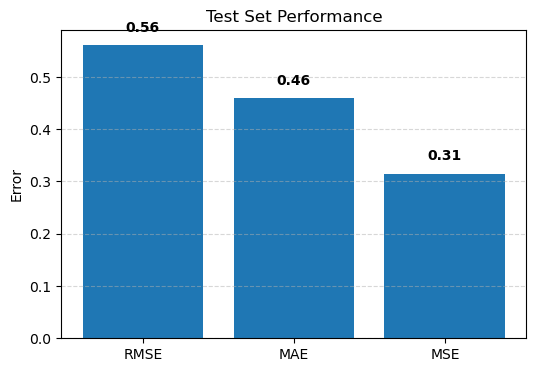

In [49]:
from surprise.accuracy import mse, rmse, mae
import matplotlib.pyplot as plt

rmse_score = rmse(predictions, verbose=False)
mae_score  = mae(predictions, verbose=False)
mse_score  = mse(predictions, verbose=False)

metrics = ['RMSE', 'MAE', 'MSE']
scores  = [rmse_score, mae_score, mse_score]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(metrics, scores)

for i, v in enumerate(scores):
    ax.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')

ax.set_ylabel("Error")
ax.set_title("Test Set Performance")
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [50]:
K = 10
top_k_preds = get_top_k(predictions, k=K)
relevant_items = get_true_positives(testset, threshold=4.0)

prec = precision_at_k(top_k_preds, relevant_items, k=K)
hit = hit_rate_at_k(top_k_preds, relevant_items)

print(f'Precision@{K}: {prec:.4f}')
print(f'Hit Rate@{K}: {hit:.4f}')

Precision@10: 0.1274
Hit Rate@10: 0.9988


In [51]:
# Example
def recommend_user(algo, trainset, user_id, N=5):
    """
    Returns a list of (item_id, estimated_score) for the top-N
    items the user has not yet rated.
    """
    try:
        inner_uid = trainset.to_inner_uid(user_id)
    except ValueError:
        return []  # user not in trainset

    # items the user has already rated
    seen_iids = {iid for (iid, _) in trainset.ur[inner_uid]}
    # map all internal iids back to raw ids
    raw_iids = [trainset.to_raw_iid(i) for i in trainset.all_items()]

    # candidates = those the user hasn't seen
    candidates = [iid for iid in raw_iids if trainset.to_inner_iid(iid) not in seen_iids]

    # predict each candidate
    scores = [(iid, algo.predict(user_id, iid).est) for iid in candidates]
    # sort by score descending and take top N
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:N]

for user in ['Boilermaker88', 'budgood1', 'draheim']:
    top5 = recommend_user(algo, trainset, user, N=5)
    print(f"\nTop-5 recommendations for {user}:")
    for beer_id, score in top5:
        print(f"  Beer {beer_id}: {score:.2f}")


Top-5 recommendations for Boilermaker88:
  Beer 7971: 4.20
  Beer 1545: 4.18
  Beer 11757: 4.15
  Beer 19960: 4.14
  Beer 16814: 4.10

Top-5 recommendations for budgood1:
  Beer 7971: 4.06
  Beer 1545: 4.04
  Beer 11757: 4.01
  Beer 19960: 4.00
  Beer 16814: 3.96

Top-5 recommendations for draheim:
  Beer 7971: 4.26
  Beer 1545: 4.24
  Beer 11757: 4.20
  Beer 19960: 4.19
  Beer 16814: 4.15


# Comparison Summary: User-Based KNNBaseline With vs Without Sentiment Score

The user-based KNNBaseline model with sentiment score (`overall_r_star`) shows a clear improvement over the version without sentiment:

- **RMSE** decreased from **0.800** to **0.55**
- **MAE** decreased from **0.670** to **0.44**
- **MSE** decreased from **0.650** to **0.303**

These results indicate that incorporating aspect-level sentiment information significantly improves the model's ability to predict user preferences more accurately.